# Running a PSV-Tank Simulation [1]
### First, Importing required packages & libraries
**WNTR** for running EPANET simulations in Python  
**NUMPY & PANDAS** for data handling and processing  
**MatPlotLib** for plotting output  
**timeit** for execution time of EPANET simulation (To compare computational efficiency)  
**re** for searching and matching text in the .inp file using regular expressions

In [11]:
import wntr  
import numpy as np 
import pandas as pd
import matplotlib as mpl
from matplotlib import figure
import matplotlib.pyplot as plt
import timeit 
import re

### Specifying paths for simulation files and preprocessing the input
**Warning:** *Paths in this script (and the rest of this repo) are absolute unless running the network files provided within the repo*  
Input filename (with extensions) as string.  
For running the .inp files in this repository, you can use this relative path `"../../Network-Files/Network X/"` where X is the network number 

In [12]:
 # Replace with appropriate path and filename
directory='../../Network-Files/Network 3/'
filename='Network3_4hr_PSV-Tank.inp'
name_only=filename[0:-4]
print("Selected File: ",name_only)
abs_path=directory+filename

Selected File:  Network3_4hr_PSV-Tank


### Get Relevant Data from .inp file using WNTR
Some key input are needed for postprocessing purposes, and thus need to be extracted from the .inp file  
Such as:  
* Supply duration for volume calculations  
  
First, we build the network model using WNTR's network module  
then we extract the needed data from the objects built by the network model

In [13]:
# create network model from input file
network = wntr.network.WaterNetworkModel(abs_path)

## Extract Supply Duration from .inp file
supply_duration=int(network.options.time.duration/60)    # in minutes

### Running an EPANET simulation through WNTR


In [14]:
# run simulation
sim = wntr.sim.EpanetSimulator(network)
# store results of simulation
results=sim.run_sim()

### (OPTIONAL) Running a timed simulation 
for assessing computational efficiency. Requires a number of iterations to average timing over.

In [15]:
# # Specify number of iterations to time and average over (more= more confidence in mean time per run)
# n_iterations=1000

# # Statement to be timed: read filename, create network model, run network simulation
# timed_lines='inp_file='+"'"+abs_path+"'"
# timed_lines=timed_lines+'''
# wn = wntr.network.WaterNetworkModel(inp_file) 
# wntr.sim.EpanetSimulator(wn)
# '''

# # Time and average over number of iterations
# time=np.round(timeit.timeit(stmt=timed_lines,setup='import wntr',number=n_iterations)/n_iterations*1000,decimals=2)
# print("Time taken for ",filename,' is ', time, 'milliseconds per run')

### Extracting and filtering the results
Since demand nodes are tanks in this method, pressures at these nodes represent water height in the tank  
**IMPORTANT** this implementation assumes that total tank heights are 1 metres, and thus water height in the tank is equivalent to the percentage of consumer demand delivered (since full demand is equivalent to 1 m). If tank height changes please add a factor to scale the results. e.g., if tank height is 0.5 m, multiply timesrs by 2.  
**NOTE TO SELF: ADJUST THIS** The extracted results are filtered to retain only the tanks which are the demand nodes in this method for further processing

In [16]:
timesrs=pd.DataFrame()
timesrs[0]=results.node['pressure'].loc[0,:]
for i in range(1,supply_duration+1):
    # Extract Node Pressures from Results
    timesrs=pd.concat([timesrs,results.node['pressure'].loc[i*60,:]],axis=1)

# Transpose DataFrame such that indices are time (sec) and Columns are each Node
timesrs=timesrs.T
# Filter DataFrame for Columns that contain Data for demand nodes only i.e., Tanks in STM
timesrs=timesrs.filter(regex='AT\D+',axis=1)

### Calculating Consumer Satisfaction Statistics
To get a better grasp of how the demands were distributed among consumers, we calculate some descriptive stats at each time step  
**Mean Satisfaction** describes the average state throughout the network, only reaches 100 if all demands are satisfied  
**Low percentile, Median, and High Percentile** at each time step for a sense of the shape of the distribution (for equality considerations) with time  
Choose the low percentile number desired (e.g., 10<sup>th</sup> percentile) and the high percentile (e.g., 90<sup>th</sup> Percentile) by changing their respective values below 

In [17]:
# Intialize Series for storing statistics
mean=pd.Series(dtype='float64')
median=pd.Series(dtype='float64')
low_percentile=pd.Series(dtype='float64')
high_percentile=pd.Series(dtype='float64')

# Set the percentile values to be calculated
low_percent_val=10   # Range 0 to 100 ONLY
high_percent_val=90  # Range 0 to 100 ONLY

# Loop over each row (time step) in the results and calculate values of mean, median, low and high percentiles
for row in timesrs.index:
    mean.loc[row]=np.mean(timesrs.loc[row,:])*100
    low_percentile.loc[row]=np.percentile(timesrs.loc[row,:],low_percent_val)*100
    median.loc[row]=np.percentile(timesrs.loc[row,:],50)*100
    high_percentile.loc[row]=np.percentile(timesrs.loc[row,:],high_percent_val)*100

### (Optional) Save .csv files with  Results & Stats
Comment out any files you do not need, or skip this cell entirely if you don't want any files saved to your local device

In [18]:
# Saves Entire Results DataFrame as Filename_TimeSeries.csv in the same path
timesrs.to_csv(directory+name_only+"_TimeSeries.csv")

# Saves Mean Satisfaction with time as Filename_Means.csv in the same path
mean.to_csv(directory+name_only+"_Means.csv")

# Saves Median Satisfaction with time as Filename_Medians.csv in the same path
median.to_csv(directory+name_only+"_Medians.csv")

# Saves the specified low percentile (XX) values with time as Filename_XXthPercentile.csv in the same path
low_percentile.to_csv(directory+name_only+"_"+str(low_percent_val)+"thPercentile.csv")

# Saves the specified high percentile (YY) values with time as Filename_YYthPercentile.csv in the same path
high_percentile.to_csv(directory+name_only+"_"+str(high_percent_val)+"thPercentile.csv")

### Result Visualisation
First we plot the Mean satisfaction in the network with time

<function matplotlib.pyplot.show(close=None, block=None)>

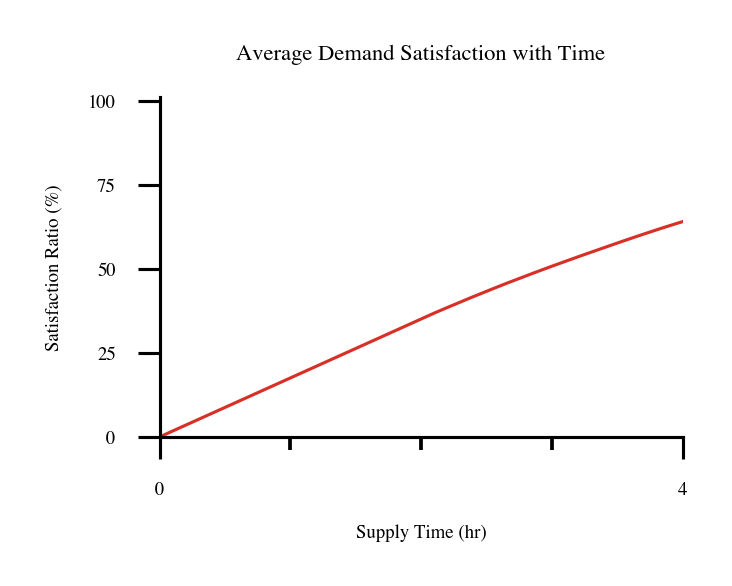

In [19]:
# Setting Universal Parameters for plotting: dots per inch (dpi), text font and size, label size
mpl.rcParams['figure.dpi'] = 450
font = {'family' : 'Times',
        'weight' : 'bold',
        'size'   : 3}
mpl.rc('font', **font)
mpl.rc('xtick', labelsize=3)
mpl.rcParams['axes.linewidth'] = 0.5

# Prepping an xaxis with hr format
supply_duration_hr=supply_duration/60
xaxis=np.arange(0,supply_duration_hr+0.00001,1/60)

fig, ax=plt.subplots()
# Change figure size (and aspect ratio) by adjusting height and width here
fig.set_figwidth(1.5)
fig.set_figheight(1)

# Formatting Plot: Setting a Title, x- and y-axis limits, major and minor ticks
ax.set_title('Average Demand Satisfaction with Time')
ax.set_xlim(0,supply_duration_hr)
ax.set_ylim(0,101)
ax.set_xticks(np.arange(0,supply_duration_hr+1,4))
ax.set_xticks(np.arange(0,supply_duration_hr+1,1),minor=True)
ax.set_yticks(np.arange(0,101,25))
ax.tick_params(width=0.5)

# Data to be plotted: Mean as a percentage (hence the multiplication by 100)
# Change color by changing the string next to c= and linewidth by value
line1,=ax.plot(xaxis,mean, c='#d73027',linewidth=0.5)
plt.xlabel('Supply Time (hr)')
plt.ylabel('Satisfaction Ratio (%)')
# Optional: show grid or turn on and off spines (Plot box sides)
# ax.grid(visible=True,which='both')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show

### Plotting the Distribution between Consumers (Equality)
Low Percentile, Median and High Percentile are plotted together to show the distribution between consumers with time. Area between Low and High Percentiles will be shaded

<function matplotlib.pyplot.show(close=None, block=None)>

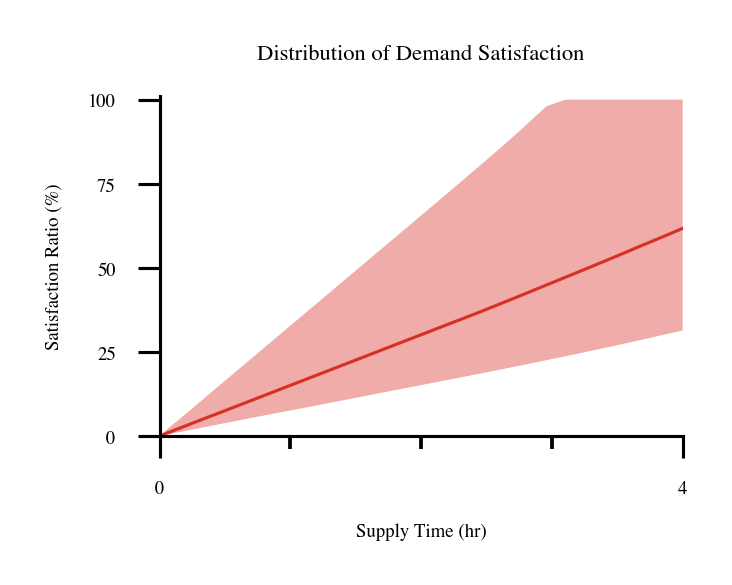

In [20]:
# Prepping an xaxis with hr format
supply_duration_hr=supply_duration/60
xaxis=np.arange(0,supply_duration_hr+0.00001,1/60)

fig, ax=plt.subplots()
# Change figure size (and aspect ratio) by adjusting height and width here
fig.set_figwidth(1.5)
fig.set_figheight(1)

# Formatting Plot: Setting a Title, x- and y-axis limits, major and minor ticks
ax.set_title('Distribution of Demand Satisfaction')
ax.set_xlim(0,supply_duration_hr)
ax.set_ylim(0,101)
ax.set_xticks(np.arange(0,supply_duration_hr+1,4))
ax.set_xticks(np.arange(0,supply_duration_hr+1,1),minor=True)
ax.set_yticks(np.arange(0,101,25))
ax.tick_params(width=0.5)


# Data to be plotted: Mean as a percentage (hence the multiplication by 100)
# Change color by changing the string next to c= and linewidth by value
line1,=ax.plot(xaxis,median, c='#d73027',linewidth=0.5)
plt.fill_between(xaxis, y1=low_percentile, y2=high_percentile, alpha=0.4, color='#d73027', edgecolor=None)
plt.xlabel('Supply Time (hr)')
plt.ylabel('Satisfaction Ratio (%)')
# Optional: show grid or turn on and off spines (Plot box sides)
# ax.grid(visible=True,which='both')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show

### References:
##### [1] P. Sivakumar, N. B. Gorev, T. T. Tanyimboh, I. F. Kodzhespirova, C. R. Suribabu, and T. R. Neelakantan, “Dynamic Pressure-Dependent Simulation of Water Distribution Networks Considering Volume-Driven Demands Based on Noniterative Application of EPANET 2,” Journal of Water Resources Planning and Management, vol. 146, no. 6, p. 06020005, Jun. 2020, doi: 10.1061/(asce)wr.1943-5452.0001220.